In [1]:
# Use a dask client
from dask.distributed import Client, LocalCluster, worker, progress, wait
import dask
from dask_jobqueue import SLURMCluster


In [2]:
cluster = SLURMCluster()
client=Client(cluster)
cluster.scale(40)
client


Bad key "backend.qt5" on line 5 in
/home/mrayson/.config/matplotlib/matplotlibrc.
You probably need to get an updated matplotlibrc file from
http://github.com/matplotlib/matplotlib/blob/master/matplotlibrc.template
or from the matplotlib source distribution


<Client: 'tcp://146.118.38.93:33665' processes=0 threads=0, memory=0 B>

In [3]:
import xarray as xr
import matplotlib.pyplot as plt
import numpy as np
from ipywidgets import interact, interactive, fixed, interact_manual
import pandas as pd
from matplotlib import animation
import glob
import cmocean
import cartopy
import zarr

from matplotlib.colors import LightSource
from scipy import ndimage
# import geoviews as gv
# import geoviews.feature as gf

In [4]:
plt.rcParams['font.size'] = 14
plt.rcParams['axes.labelsize'] = 'large'

In [5]:
%matplotlib inline

In [6]:
# Open the object as a zarr file
outpath = '/home/mrayson/scratch/HIMAWARI/raw_zarr'
ds = xr.open_zarr(outpath)
ds.time.values[0],ds.time.values[-1]

(numpy.datetime64('2016-01-01T00:00:17.000000000'),
 numpy.datetime64('2019-12-31T23:00:17.000000000'))

/home/mrayson/group/mrayson/miniconda3/envs/soda/lib/python3.7/site-packages/pandas/plotting/_matplotlib/converter.py:103: FutureWarning: Using an implicitly registered datetime converter for a matplotlib plotting method. The converter was registered by pandas on import. Future versions of pandas will require you to explicitly register matplotlib converters.

To register the converters:
	>>> from pandas.plotting import register_matplotlib_converters
	>>> register_matplotlib_converters()
  warnings.warn(msg, FutureWarning)


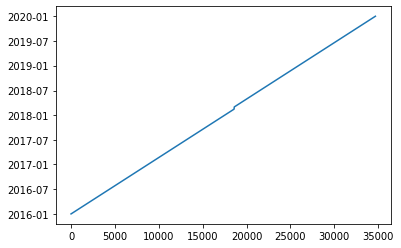

In [7]:
plt.figure()
plt.plot(ds.time)

In [8]:
t1 = '2016-01-01'
t2 = '2017-01-01'

#ds.sea_surface_temperature.sel(time=t1).time
sst = ds['sea_surface_temperature'].sel(time=slice(t1,t2))
sst.nbytes/1e9
sst

<xarray.DataArray 'sea_surface_temperature' (time: 8805, lat: 6001, lon: 6001)>
dask.array<getitem, shape=(8805, 6001, 6001), dtype=float32, chunksize=(1, 6001, 6001), chunktype=numpy.ndarray>
Coordinates:
  * lat      (lat) float32 60.0 59.98 59.96 59.94 ... -59.96 -59.979996 -60.0
  * lon      (lon) float32 80.0 80.02 80.04 80.06 ... 199.95999 199.98 200.0
  * time     (time) datetime64[ns] 2016-01-01T00:00:17 ... 2017-01-01T23:00:17
Attributes:
    comment:        Temperature of the skin of the ocean.
    grid_mapping:   Equirectangular
    long_name:      sea surface skin temperature
    standard_name:  sea_surface_skin_temperature
    units:          kelvin
    valid_max:      5000
    valid_min:      -200

In [9]:
# Compute the monthly means
climatology = sst.groupby('time.month').mean('time')
climatology


<xarray.DataArray 'sea_surface_temperature' (month: 12, lat: 6001, lon: 6001)>
dask.array<stack, shape=(12, 6001, 6001), dtype=float32, chunksize=(1, 6001, 6001), chunktype=numpy.ndarray>
Coordinates:
  * lat      (lat) float32 60.0 59.98 59.96 59.94 ... -59.96 -59.979996 -60.0
  * lon      (lon) float32 80.0 80.02 80.04 80.06 ... 199.95999 199.98 200.0
  * month    (month) int64 1 2 3 4 5 6 7 8 9 10 11 12

In [10]:
# Load the January mean into memory
sst_jan = climatology[8].persist()

In [11]:
sst_jan_C = sst_jan - 273.15
sst_jan_C

<xarray.DataArray 'sea_surface_temperature' (lat: 6001, lon: 6001)>
dask.array<sub, shape=(6001, 6001), dtype=float32, chunksize=(6001, 6001), chunktype=numpy.ndarray>
Coordinates:
  * lat      (lat) float32 60.0 59.98 59.96 59.94 ... -59.96 -59.979996 -60.0
  * lon      (lon) float32 80.0 80.02 80.04 80.06 ... 199.95999 199.98 200.0
    month    int64 9

In [12]:
# Smooth the SST image
s = 4
w = 10
t = (((w - 1)/2)-0.5)/s
#sst_snap_C.values = ndimage.gaussian_filter(sst_snap_C, sigma=s, truncate=t)
sst_jan_C.values = ndimage.gaussian_filter(sst_jan_C, sigma=s, truncate=t)

In [13]:
# Grab a snapshot
sst_snap = sst.sel(time=slice('2016-08-10 02:00:00','2016-08-10 03:00:00')).mean(axis=0).persist()
sst_snap_C = sst_snap - 273.15
sst_snap_C=sst_snap_C.assign_coords({'lon': (((sst_snap_C.lon ) % 360))})

sst_snap_C

<xarray.DataArray 'sea_surface_temperature' (lat: 6001, lon: 6001)>
dask.array<sub, shape=(6001, 6001), dtype=float32, chunksize=(6001, 6001), chunktype=numpy.ndarray>
Coordinates:
  * lat      (lat) float32 60.0 59.98 59.96 59.94 ... -59.96 -59.979996 -60.0
  * lon      (lon) float32 80.0 80.02 80.04 80.06 ... 199.95999 199.98 200.0

In [14]:
# Smooth the SST image
s = 2.
w = 5
t = (((w - 1)/2)-0.5)/s
sst_snap_C.values = ndimage.gaussian_filter(sst_snap_C, sigma=s, truncate=t)


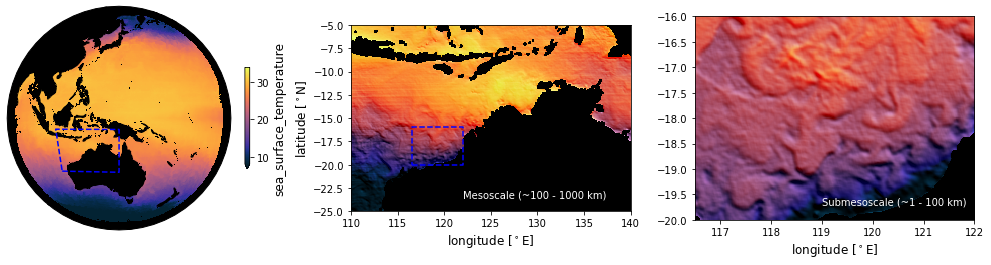

In [27]:
prj = cartopy.crs.NearsidePerspective(central_longitude=140, central_latitude=0,)
                                     #satellite_height=33e6)

img_proj =  cartopy.crs.PlateCarree()
# ex1 = prj.transform_point(sst_jan_C.lon[0], sst_jan_C.lat[0], cartopy.crs.PlateCarree())
# ex2 = prj.transform_point(sst_jan_C.lon[-1], sst_jan_C.lat[-1], cartopy.crs.PlateCarree())
# img_extent = [ex1[0],ex2[0],ex1[1],ex2[1]]
#prj = cartopy.crs.Orthographic(-10, 45)
#prj = cartopy.crs.PlateCarree()
plt.figure(figsize=(14,4))
#ax = plt.subplot2grid((2,2),(0,0),rowspan=2, projection=prj)
ax = plt.subplot2grid((1,3),(0,0), projection=prj, )
ax.background_patch.set_facecolor('k')
sst_jan_C[::20,::20].plot.imshow(cmap=cmocean.cm.thermal, vmin=8, vmax=34, ax=ax,\
           transform=img_proj, origin='upper',cbar_kwargs={'shrink': 0.4} ,)
#extent=img_extent,
# sst_snap_C.plot.imshow(cmap=cmocean.cm.thermal, vmin=10, vmax=32, ax=ax,\
#            transform=img_proj, extent=img_extent, origin='upper' )
ax.coastlines()
plt.title('')

ax2 = plt.subplot2grid((1,3),(0,1),)

ls = LightSource(azdeg=30, altdeg=25)

extent = [110,140,-25,-5]
ax.plot([extent[0],extent[1],extent[1],extent[0],extent[0]],
        [extent[2],extent[2],extent[3],extent[3],extent[2]],'b--', transform=img_proj)

ve=10.5
#Z =sst_snap_C.sel(lon=slice(extent[0],extent[1]),lat=slice(extent[3],extent[2])).values
Z =sst_jan_C.sel(lon=slice(extent[0],extent[1]),lat=slice(extent[3],extent[2])).values

ax2.imshow(ls.shade(Z, vert_exag=ve, blend_mode='overlay',cmap=cmocean.cm.thermal, vmin=23, vmax=30,), extent=extent )
#ax2.imshow(Z,cmap=cmocean.cm.thermal, extent=extent, vmin=25, vmax=31, )
ax2.set_aspect('equal')
plt.ylabel('latitude [$^\circ$N]')
plt.xlabel('longitude [$^\circ$E]')


ax2.text(122, -23.5,'Mesoscale (~100 - 1000 km)', fontdict={'color':'w'})

ax3 = plt.subplot2grid((1,3),(0,2),)

extent = [116.5,122,-21,-15]
extent = [116.5,122,-20,-16]


ax2.plot([extent[0],extent[1],extent[1],extent[0],extent[0]],
        [extent[2],extent[2],extent[3],extent[3],extent[2]],'b--')
#extent = [117,121,-19,-16]
ve=3.25

Z =sst_snap_C.sel(lon=slice(extent[0],extent[1]),lat=slice(extent[3],extent[2])).values
#ax3.imshow(Z,cmap=cmocean.cm.thermal, extent=extent, vmin=25, vmax=30, )
ax3.imshow(ls.shade(Z, vert_exag=ve, blend_mode='overlay',cmap=cmocean.cm.thermal, vmin=23, vmax=30), extent=extent )

#ax3.imshow(ls.shade(Z, vert_exag=ve, blend_mode='hsv',cmap=plt.cm.gray),extent=extent, vmin=25, vmax=31, )
ax3.set_aspect('equal')
plt.xlabel('longitude [$^\circ$E]')

ax3.text(119, -19.7,'Submesoscale (~1 - 100 km)', fontdict={'color':'w'})

plt.tight_layout()
#ax.gridlines()
plt.savefig('FIGURES/himawari_submesoscale_v2.png',dpi=150)

In [46]:
# Grab a slice

# Mask bad flagged data
t1 = '2019-01-01'
t2 = '2020-01-01'

#ds.sea_surface_temperature.sel(time=t1).time
sst_yt = ds['sea_surface_temperature'].sel(time=slice(t1,t2), lon=slice(120,120.02), lat=slice(-10,-20)) - 273.15
sst_yt.nbytes/1e9

sst_yt.persist()

<xarray.DataArray 'sea_surface_temperature' (time: 8757, lat: 501, lon: 1)>
dask.array<sub, shape=(8757, 501, 1), dtype=float32, chunksize=(1, 501, 1), chunktype=numpy.ndarray>
Coordinates:
  * lat      (lat) float32 -10.0 -10.019997 -10.040001 ... -19.979996 -20.0
  * lon      (lon) float32 120.0
  * time     (time) datetime64[ns] 2019-01-01T00:00:17 ... 2019-12-31T23:00:17

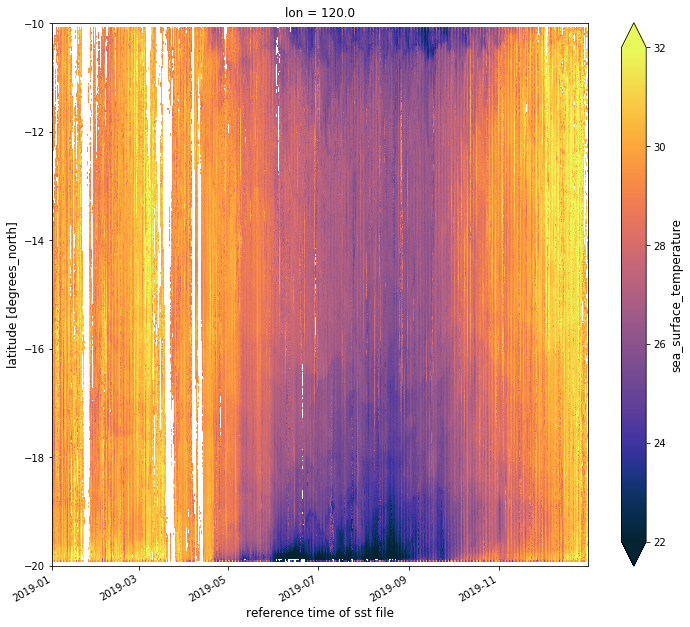

In [48]:
plt.figure(figsize=(12,10))
sst_yt.squeeze().T.plot(cmap=cmocean.cm.thermal, vmin=22, vmax=32)

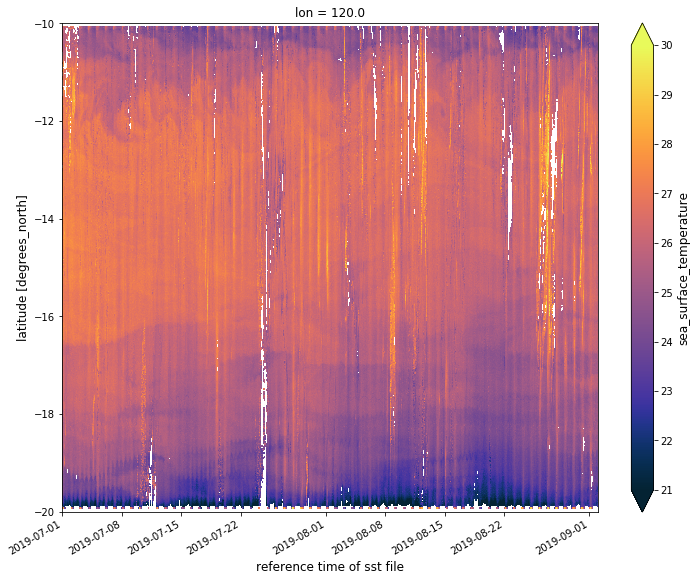

In [56]:
# Grab a slice

# Mask bad flagged data
t1 = '2019-07-01'
t2 = '2019-09-01'

#ds.sea_surface_temperature.sel(time=t1).time
sst_yt = ds['sea_surface_temperature'].sel(time=slice(t1,t2), lon=slice(120,120.02), lat=slice(-10,-20)) - 273.15
sst_yt.nbytes/1e9

plt.figure(figsize=(12,9))
sst_yt.squeeze().T.plot(cmap=cmocean.cm.thermal, vmin=21, vmax=30)

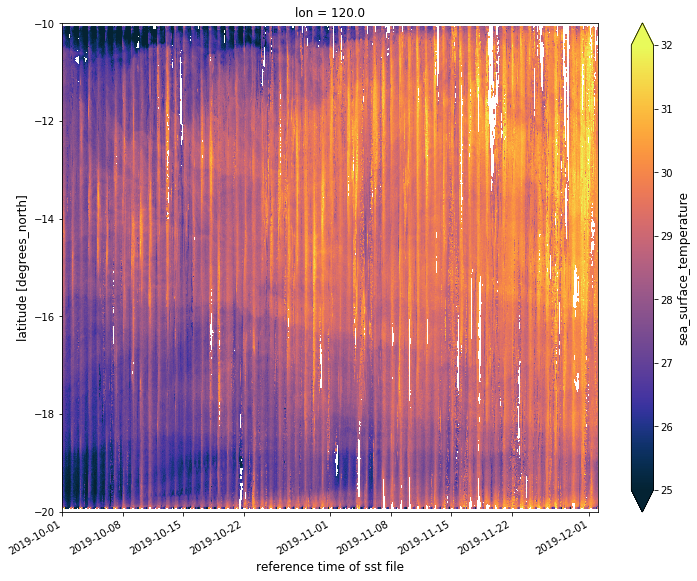

In [53]:
# Grab a slice

# Mask bad flagged data
t1 = '2019-10-01'
t2 = '2019-12-01'

#ds.sea_surface_temperature.sel(time=t1).time
sst_yt = ds['sea_surface_temperature'].sel(time=slice(t1,t2), lon=slice(120,120.02), lat=slice(-10,-20)) - 273.15
sst_yt.nbytes/1e9

plt.figure(figsize=(12,9))
sst_yt.squeeze().T.plot(cmap=cmocean.cm.thermal, vmin=25, vmax=32)

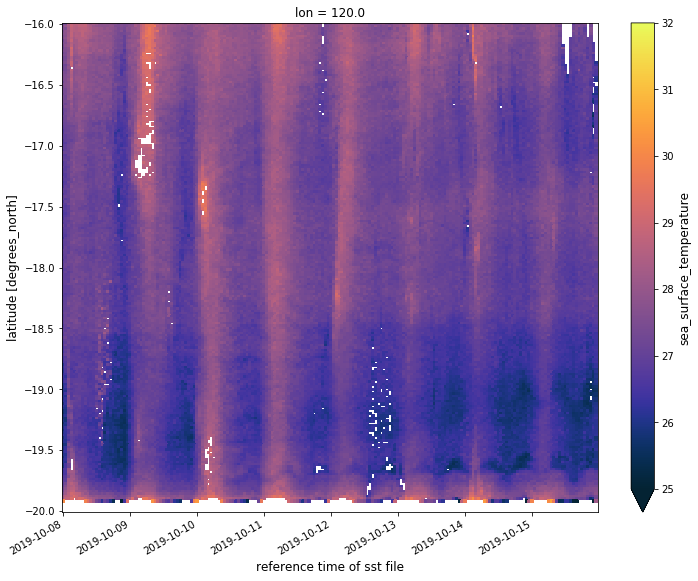

In [55]:
# Grab a slice

# Mask bad flagged data
t1 = '2019-10-08'
t2 = '2019-10-15'

#ds.sea_surface_temperature.sel(time=t1).time
sst_yt = ds['sea_surface_temperature'].sel(time=slice(t1,t2), lon=slice(120,120.02), lat=slice(-16,-20)) - 273.15
sst_yt.nbytes/1e9

plt.figure(figsize=(12,9))
sst_yt.squeeze().T.plot(cmap=cmocean.cm.thermal, vmin=25, vmax=32)

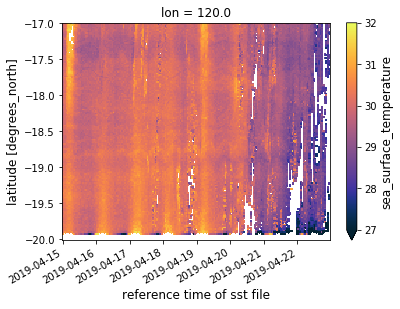

In [44]:
t1 = '2019-04-15'
t2 = '2019-04-22'

#ds.sea_surface_temperature.sel(time=t1).time
sst_yt = ds['sea_surface_temperature'].sel(time=slice(t1,t2), lon=slice(120,120.02), lat=slice(-17,-20)) - 273.15
sst_yt.nbytes/1e9

plt.figure()
sst_yt.squeeze().T.plot(cmap=cmocean.cm.thermal, vmin=27, vmax=32)

# Old stuff

In [27]:
ds.time.values[0], ds.time.values[-1]

(numpy.datetime64('2016-07-01T00:00:17.000000000'),
 numpy.datetime64('2016-07-31T23:00:17.000000000'))

In [10]:
temp = ds.sea_surface_temperature.where(ds.quality_level>4, np.nan)


In [14]:
# Load some bathy data
dsz = xr.open_dataset('/home/mrayson/group/mrayson/DATA/BATHYMETRY//TimorSea_GAWEL_Multi_GEBCO_Combined_DEM.nc')
# dsz.set_coords({'X':dsz.X,'Y':dsz.Y})
# dsz.topo.swap_dims({'ny':dsz.Y.values, 'nx':dsz.X.values})
topo = xr.DataArray(dsz.topo.values, dims=('Y','X'), coords={'X':dsz.X.values, 'Y':dsz.Y.values})

In [16]:
def plot_sst_scene(ax, temp,t1,t2, xlims=(112,128), ylims=(-24,-12), cbar=True):
    mu_temp = temp.sel(time=slice(t1,t2)).mean(axis=0)
    dTdx,dTdy = np.gradient(mu_temp, 2e3,2e3)

    dT = np.abs(dTdx+1j*dTdy)
    # plt.pcolormesh(temp.lon, temp.lat, dT, cmap='Blues',vmin=0, vmax=1e-4)
    P = mu_temp.plot(ax=ax, cmap='Spectral_r',vmin=273+23,vmax=273+31, add_colorbar=cbar )
    C = plt.contour(temp.lon, temp.lat, dT, [4e-5,],colors='k',linewidths=0.5)
    
    topo.sel(X=slice(xlims[0],xlims[1]), Y=slice(ylims[0],ylims[1])).plot.contour(\
                    levels=[-1000,-200],colors='0.5',linewidths=1, linestyles='--')
    
    plt.ylim(ylims)
    plt.xlim(xlims)
    # plt.ylim(-22,-16)
    # plt.xlim(114,120)
    plt.gca().set_aspect('equal')
    T = plt.text(116,-23,'Himawari-8 Sea Surface Temperature [K]\nAverage Time:\n    {} - {}'.format(t1,t2))
    
    plt.tight_layout()
    
    return P, C, T

def plot_sstgrad_scene(ax, temp,t1,t2, xlims=(112,128), ylims=(-24,-12), cbar=True):
    mu_temp = temp.sel(time=slice(t1,t2)).mean(axis=0)
    dTdx,dTdy = np.gradient(mu_temp, 2e3,2e3)

    dT = np.abs(dTdx+1j*dTdy)
    C= plt.pcolormesh(temp.lon, temp.lat, dT, cmap='bone_r',vmin=1e-5, vmax=1e-4)
    #P = mu_temp.plot(ax=ax, cmap='Spectral_r',vmin=273+23,vmax=273+31, add_colorbar=cbar )
    #C = plt.contour(temp.lon, temp.lat, dT, [4e-5,],colors='k',linewidths=0.5)
    if cbar:
        plt.colorbar()
    
    topo.sel(X=slice(xlims[0],xlims[1]), Y=slice(ylims[0],ylims[1])).plot.contour(\
                    levels=[-1000,-200],colors='0.5',linewidths=1, linestyles='--')
    
    plt.ylim(ylims)
    plt.xlim(xlims)
    # plt.ylim(-22,-16)
    # plt.xlim(114,120)
    plt.gca().set_aspect('equal')
    T = plt.text(116,-23,'Himawari-8 Sea Surface Temperature gradient [K/m]\nAverage Time:\n    {} - {}'.format(t1,t2))
    
    plt.tight_layout()
    
    return C, T
    


TypeError: 'NoneType' object is not subscriptable

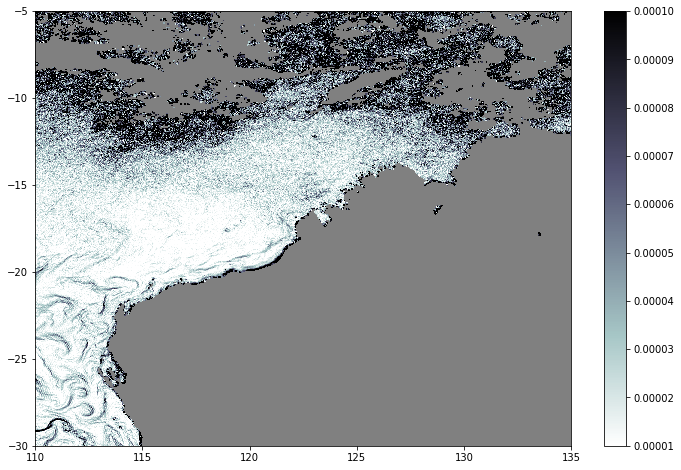

In [18]:
plt.figure(figsize=(12,8))
ax = plt.subplot(111, facecolor='0.5')
plot_sstgrad_scene(ax, temp,'2017-04-01 12:00:00','2017-04-04 12:00:00',xlims=None,ylims=None)

/cvmfs/sft.cern.ch/lcg/views/LCG_96python3/x86_64-centos7-gcc8-opt/lib/python3.6/site-packages/dask/array/numpy_compat.py:28: RuntimeWarning: invalid value encountered in true_divide
  x = np.divide(x1, x2, out)


(<matplotlib.collections.QuadMesh at 0x7ff0a967d4e0>,
 Text(116, -23, 'Himawari-8 Sea Surface Temperature [K]\nAverage Time:\n    2019-03-26 12:00:00 - 2019-03-29 12:00:00'))

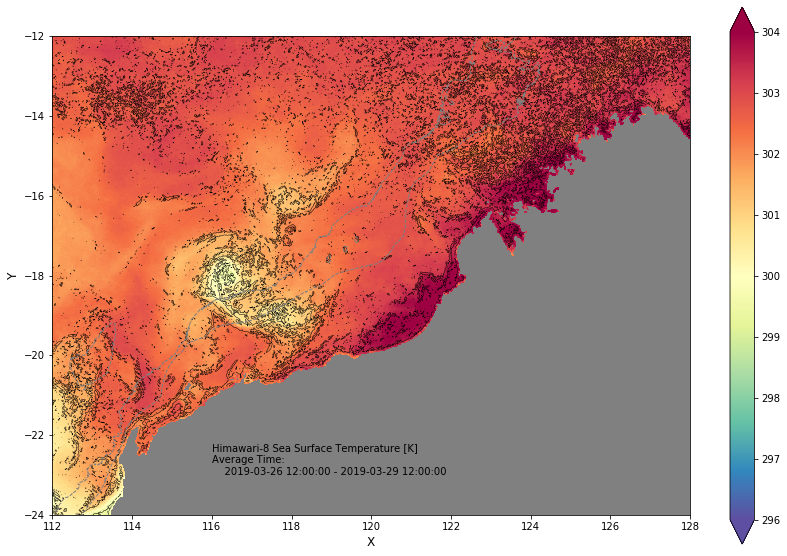

In [10]:
plt.figure(figsize=(12,8))
ax = plt.subplot(111, facecolor='0.5')
plot_sst_scene(ax, temp,'2019-03-26 12:00:00','2019-03-29 12:00:00')

/cvmfs/sft.cern.ch/lcg/views/LCG_96python3/x86_64-centos7-gcc8-opt/lib/python3.6/site-packages/dask/array/numpy_compat.py:28: RuntimeWarning: invalid value encountered in true_divide
  x = np.divide(x1, x2, out)


(<matplotlib.collections.QuadMesh at 0x7ff0a1b63710>,
 Text(116, -23, 'Himawari-8 Sea Surface Temperature [K]\nAverage Time:\n    2019-04-01 12:00:00 - 2019-04-04 12:00:00'))

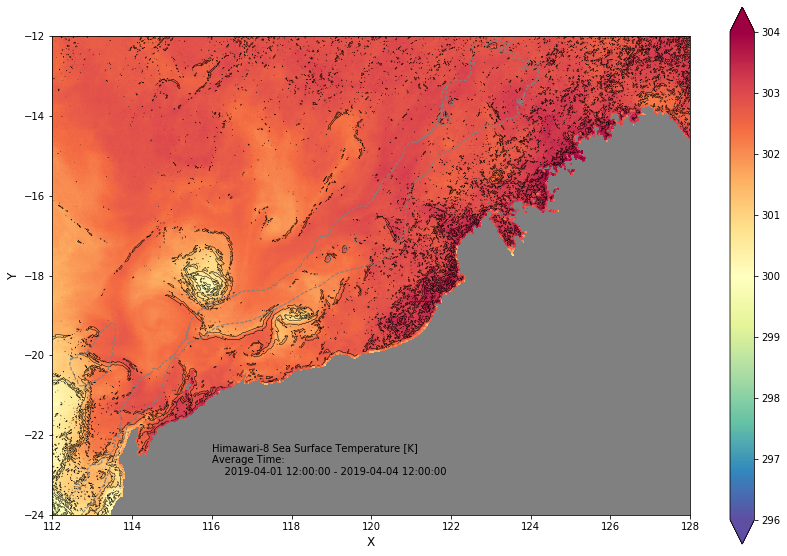

In [11]:
plt.figure(figsize=(12,8))
ax = plt.subplot(111, facecolor='0.5')
plot_sst_scene(ax, temp,'2019-04-01 12:00:00','2019-04-04 12:00:00')

/cvmfs/sft.cern.ch/lcg/views/LCG_96python3/x86_64-centos7-gcc8-opt/lib/python3.6/site-packages/dask/array/numpy_compat.py:28: RuntimeWarning: invalid value encountered in true_divide
  x = np.divide(x1, x2, out)


(<matplotlib.collections.QuadMesh at 0x7ff0a96d3668>,
 Text(116, -23, 'Himawari-8 Sea Surface Temperature [K]\nAverage Time:\n    2019-04-15 12:00:00 - 2019-04-18 12:00:00'))

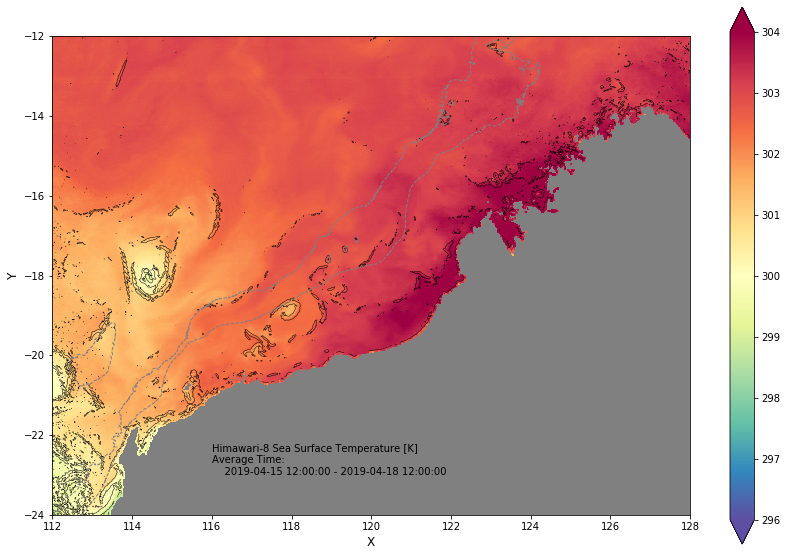

In [12]:
plt.figure(figsize=(12,8))
ax = plt.subplot(111, facecolor='0.5')
plot_sst_scene(ax, temp,'2019-04-15 12:00:00','2019-04-18 12:00:00')

/cvmfs/sft.cern.ch/lcg/views/LCG_96python3/x86_64-centos7-gcc8-opt/lib/python3.6/site-packages/dask/array/numpy_compat.py:28: RuntimeWarning: invalid value encountered in true_divide
  x = np.divide(x1, x2, out)


(<matplotlib.collections.QuadMesh at 0x7ff097939390>,
 Text(116, -23, 'Himawari-8 Sea Surface Temperature [K]\nAverage Time:\n    2019-05-01 12:00:00 - 2019-05-04 12:00:00'))

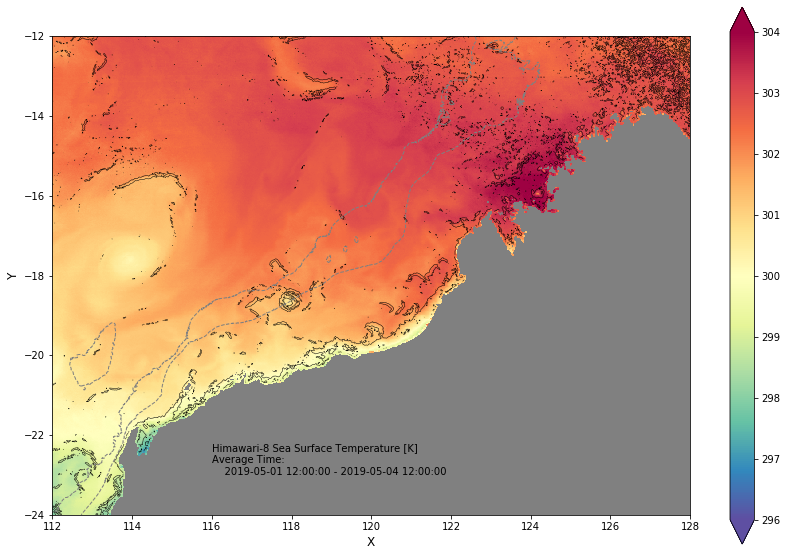

In [13]:
plt.figure(figsize=(12,8))
ax = plt.subplot(111, facecolor='0.5')
plot_sst_scene(ax, temp,'2019-05-01 12:00:00','2019-05-04 12:00:00')

/cvmfs/sft.cern.ch/lcg/views/LCG_96python3/x86_64-centos7-gcc8-opt/lib/python3.6/site-packages/dask/array/numpy_compat.py:28: RuntimeWarning: invalid value encountered in true_divide
  x = np.divide(x1, x2, out)


(<matplotlib.collections.QuadMesh at 0x7ff092973908>,
 Text(116, -23, 'Himawari-8 Sea Surface Temperature [K]\nAverage Time:\n    2019-05-01 12:00:00 - 2019-05-04 12:00:00'))

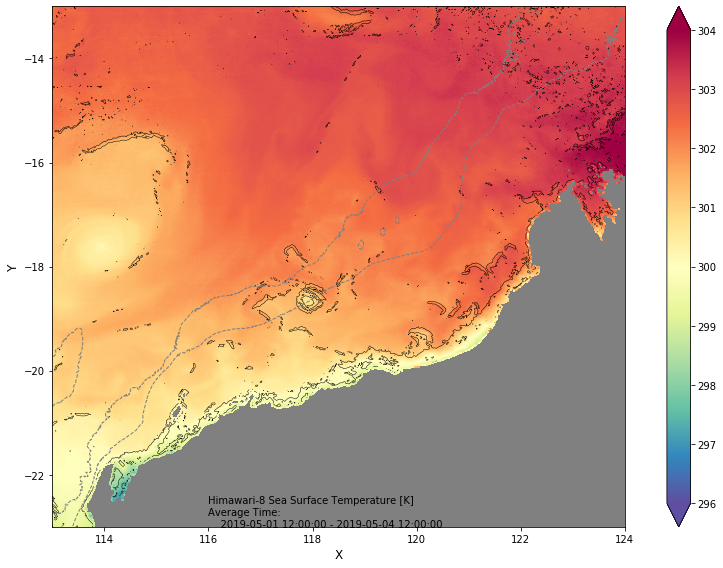

In [14]:
plt.figure(figsize=(12,8))
ax = plt.subplot(111, facecolor='0.5')
plot_sst_scene(ax, temp,'2019-05-01 12:00:00','2019-05-04 12:00:00', xlims=(113,124), ylims=(-23,-13))

/cvmfs/sft.cern.ch/lcg/views/LCG_96python3/x86_64-centos7-gcc8-opt/lib/python3.6/site-packages/dask/array/numpy_compat.py:28: RuntimeWarning: invalid value encountered in true_divide
  x = np.divide(x1, x2, out)


(<matplotlib.collections.QuadMesh at 0x7ff08da3f7b8>,
 Text(116, -23, 'Himawari-8 Sea Surface Temperature [K]\nAverage Time:\n    2019-04-01 12:00:00 - 2019-04-04 12:00:00'))

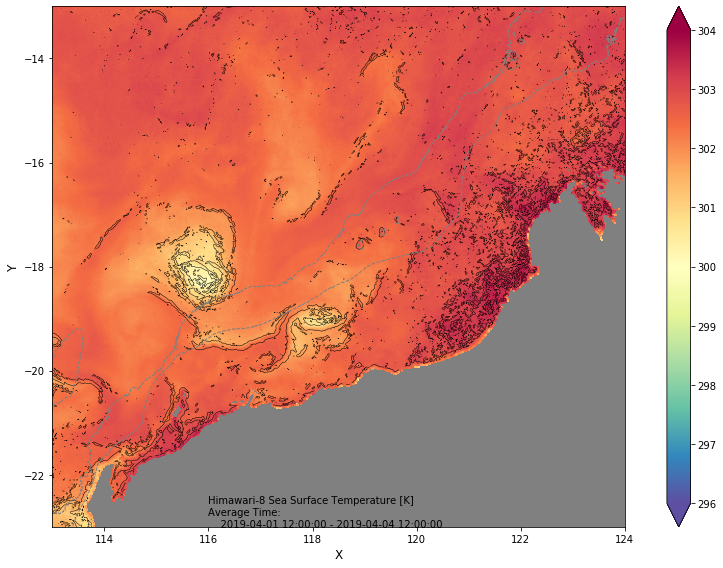

In [15]:
plt.figure(figsize=(12,8))
ax = plt.subplot(111, facecolor='0.5')
plot_sst_scene(ax, temp,'2019-04-01 12:00:00','2019-04-04 12:00:00', xlims=(113,124), ylims=(-23,-13))

/cvmfs/sft.cern.ch/lcg/views/LCG_96python3/x86_64-centos7-gcc8-opt/lib/python3.6/site-packages/dask/array/numpy_compat.py:28: RuntimeWarning: invalid value encountered in true_divide
  x = np.divide(x1, x2, out)


2019-05-28 00:00:00 2019-05-31 00:00:00


/cvmfs/sft.cern.ch/lcg/views/LCG_96python3/x86_64-centos7-gcc8-opt/lib/python3.6/site-packages/dask/array/numpy_compat.py:28: RuntimeWarning: invalid value encountered in true_divide
  x = np.divide(x1, x2, out)


2019-05-29 00:00:00 2019-06-01 00:00:00


/cvmfs/sft.cern.ch/lcg/views/LCG_96python3/x86_64-centos7-gcc8-opt/lib/python3.6/site-packages/dask/array/numpy_compat.py:28: RuntimeWarning: invalid value encountered in true_divide
  x = np.divide(x1, x2, out)


2019-05-30 00:00:00 2019-06-02 00:00:00


/cvmfs/sft.cern.ch/lcg/views/LCG_96python3/x86_64-centos7-gcc8-opt/lib/python3.6/site-packages/dask/array/numpy_compat.py:28: RuntimeWarning: invalid value encountered in true_divide
  x = np.divide(x1, x2, out)


2019-05-31 00:00:00 2019-06-03 00:00:00


/cvmfs/sft.cern.ch/lcg/views/LCG_96python3/x86_64-centos7-gcc8-opt/lib/python3.6/site-packages/dask/array/numpy_compat.py:28: RuntimeWarning: invalid value encountered in true_divide
  x = np.divide(x1, x2, out)


2019-06-01 00:00:00 2019-06-04 00:00:00


/cvmfs/sft.cern.ch/lcg/views/LCG_96python3/x86_64-centos7-gcc8-opt/lib/python3.6/site-packages/dask/array/numpy_compat.py:28: RuntimeWarning: invalid value encountered in true_divide
  x = np.divide(x1, x2, out)


2019-06-02 00:00:00 2019-06-05 00:00:00


/cvmfs/sft.cern.ch/lcg/views/LCG_96python3/x86_64-centos7-gcc8-opt/lib/python3.6/site-packages/dask/array/numpy_compat.py:28: RuntimeWarning: invalid value encountered in true_divide
  x = np.divide(x1, x2, out)


2019-06-03 00:00:00 2019-06-06 00:00:00


/cvmfs/sft.cern.ch/lcg/views/LCG_96python3/x86_64-centos7-gcc8-opt/lib/python3.6/site-packages/dask/array/numpy_compat.py:28: RuntimeWarning: invalid value encountered in true_divide
  x = np.divide(x1, x2, out)


2019-06-04 00:00:00 2019-06-07 00:00:00


/cvmfs/sft.cern.ch/lcg/views/LCG_96python3/x86_64-centos7-gcc8-opt/lib/python3.6/site-packages/dask/array/numpy_compat.py:28: RuntimeWarning: invalid value encountered in true_divide
  x = np.divide(x1, x2, out)


2019-06-05 00:00:00 2019-06-08 00:00:00


/cvmfs/sft.cern.ch/lcg/views/LCG_96python3/x86_64-centos7-gcc8-opt/lib/python3.6/site-packages/dask/array/numpy_compat.py:28: RuntimeWarning: invalid value encountered in true_divide
  x = np.divide(x1, x2, out)


2019-06-06 00:00:00 2019-06-09 00:00:00


/cvmfs/sft.cern.ch/lcg/views/LCG_96python3/x86_64-centos7-gcc8-opt/lib/python3.6/site-packages/dask/array/numpy_compat.py:28: RuntimeWarning: invalid value encountered in true_divide
  x = np.divide(x1, x2, out)


2019-06-07 00:00:00 2019-06-10 00:00:00


/cvmfs/sft.cern.ch/lcg/views/LCG_96python3/x86_64-centos7-gcc8-opt/lib/python3.6/site-packages/dask/array/numpy_compat.py:28: RuntimeWarning: invalid value encountered in true_divide
  x = np.divide(x1, x2, out)


2019-06-08 00:00:00 2019-06-11 00:00:00


/cvmfs/sft.cern.ch/lcg/views/LCG_96python3/x86_64-centos7-gcc8-opt/lib/python3.6/site-packages/dask/array/numpy_compat.py:28: RuntimeWarning: invalid value encountered in true_divide
  x = np.divide(x1, x2, out)


2019-06-09 00:00:00 2019-06-12 00:00:00


/cvmfs/sft.cern.ch/lcg/views/LCG_96python3/x86_64-centos7-gcc8-opt/lib/python3.6/site-packages/dask/array/numpy_compat.py:28: RuntimeWarning: invalid value encountered in true_divide
  x = np.divide(x1, x2, out)


2019-06-10 00:00:00 2019-06-13 00:00:00


/cvmfs/sft.cern.ch/lcg/views/LCG_96python3/x86_64-centos7-gcc8-opt/lib/python3.6/site-packages/dask/array/numpy_compat.py:28: RuntimeWarning: invalid value encountered in true_divide
  x = np.divide(x1, x2, out)


2019-06-11 00:00:00 2019-06-14 00:00:00


/cvmfs/sft.cern.ch/lcg/views/LCG_96python3/x86_64-centos7-gcc8-opt/lib/python3.6/site-packages/dask/array/numpy_compat.py:28: RuntimeWarning: invalid value encountered in true_divide
  x = np.divide(x1, x2, out)


2019-06-12 00:00:00 2019-06-15 00:00:00


/cvmfs/sft.cern.ch/lcg/views/LCG_96python3/x86_64-centos7-gcc8-opt/lib/python3.6/site-packages/dask/array/numpy_compat.py:28: RuntimeWarning: invalid value encountered in true_divide
  x = np.divide(x1, x2, out)


2019-06-13 00:00:00 2019-06-16 00:00:00


/cvmfs/sft.cern.ch/lcg/views/LCG_96python3/x86_64-centos7-gcc8-opt/lib/python3.6/site-packages/dask/array/numpy_compat.py:28: RuntimeWarning: invalid value encountered in true_divide
  x = np.divide(x1, x2, out)


2019-06-14 00:00:00 2019-06-17 00:00:00


/cvmfs/sft.cern.ch/lcg/views/LCG_96python3/x86_64-centos7-gcc8-opt/lib/python3.6/site-packages/dask/array/numpy_compat.py:28: RuntimeWarning: invalid value encountered in true_divide
  x = np.divide(x1, x2, out)


2019-06-15 00:00:00 2019-06-18 00:00:00


/cvmfs/sft.cern.ch/lcg/views/LCG_96python3/x86_64-centos7-gcc8-opt/lib/python3.6/site-packages/dask/array/numpy_compat.py:28: RuntimeWarning: invalid value encountered in true_divide
  x = np.divide(x1, x2, out)


2019-06-16 00:00:00 2019-06-19 00:00:00


/cvmfs/sft.cern.ch/lcg/views/LCG_96python3/x86_64-centos7-gcc8-opt/lib/python3.6/site-packages/dask/array/numpy_compat.py:28: RuntimeWarning: invalid value encountered in true_divide
  x = np.divide(x1, x2, out)


2019-06-17 00:00:00 2019-06-20 00:00:00


/cvmfs/sft.cern.ch/lcg/views/LCG_96python3/x86_64-centos7-gcc8-opt/lib/python3.6/site-packages/dask/array/numpy_compat.py:28: RuntimeWarning: invalid value encountered in true_divide
  x = np.divide(x1, x2, out)


2019-06-18 00:00:00 2019-06-21 00:00:00


/cvmfs/sft.cern.ch/lcg/views/LCG_96python3/x86_64-centos7-gcc8-opt/lib/python3.6/site-packages/dask/array/numpy_compat.py:28: RuntimeWarning: invalid value encountered in true_divide
  x = np.divide(x1, x2, out)


2019-06-19 00:00:00 2019-06-22 00:00:00


/cvmfs/sft.cern.ch/lcg/views/LCG_96python3/x86_64-centos7-gcc8-opt/lib/python3.6/site-packages/dask/array/numpy_compat.py:28: RuntimeWarning: invalid value encountered in true_divide
  x = np.divide(x1, x2, out)


2019-06-20 00:00:00 2019-06-23 00:00:00


/cvmfs/sft.cern.ch/lcg/views/LCG_96python3/x86_64-centos7-gcc8-opt/lib/python3.6/site-packages/dask/array/numpy_compat.py:28: RuntimeWarning: invalid value encountered in true_divide
  x = np.divide(x1, x2, out)


2019-06-21 00:00:00 2019-06-24 00:00:00


/cvmfs/sft.cern.ch/lcg/views/LCG_96python3/x86_64-centos7-gcc8-opt/lib/python3.6/site-packages/dask/array/numpy_compat.py:28: RuntimeWarning: invalid value encountered in true_divide
  x = np.divide(x1, x2, out)


2019-06-22 00:00:00 2019-06-25 00:00:00


/cvmfs/sft.cern.ch/lcg/views/LCG_96python3/x86_64-centos7-gcc8-opt/lib/python3.6/site-packages/dask/array/numpy_compat.py:28: RuntimeWarning: invalid value encountered in true_divide
  x = np.divide(x1, x2, out)


2019-06-23 00:00:00 2019-06-26 00:00:00


/cvmfs/sft.cern.ch/lcg/views/LCG_96python3/x86_64-centos7-gcc8-opt/lib/python3.6/site-packages/dask/array/numpy_compat.py:28: RuntimeWarning: invalid value encountered in true_divide
  x = np.divide(x1, x2, out)


2019-06-24 00:00:00 2019-06-27 00:00:00


/cvmfs/sft.cern.ch/lcg/views/LCG_96python3/x86_64-centos7-gcc8-opt/lib/python3.6/site-packages/dask/array/numpy_compat.py:28: RuntimeWarning: invalid value encountered in true_divide
  x = np.divide(x1, x2, out)


2019-06-25 00:00:00 2019-06-28 00:00:00


/cvmfs/sft.cern.ch/lcg/views/LCG_96python3/x86_64-centos7-gcc8-opt/lib/python3.6/site-packages/dask/array/numpy_compat.py:28: RuntimeWarning: invalid value encountered in true_divide
  x = np.divide(x1, x2, out)


2019-06-26 00:00:00 2019-06-29 00:00:00


/cvmfs/sft.cern.ch/lcg/views/LCG_96python3/x86_64-centos7-gcc8-opt/lib/python3.6/site-packages/dask/array/numpy_compat.py:28: RuntimeWarning: invalid value encountered in true_divide
  x = np.divide(x1, x2, out)


2019-06-27 00:00:00 2019-06-30 00:00:00


/cvmfs/sft.cern.ch/lcg/views/LCG_96python3/x86_64-centos7-gcc8-opt/lib/python3.6/site-packages/dask/array/numpy_compat.py:28: RuntimeWarning: invalid value encountered in true_divide
  x = np.divide(x1, x2, out)


2019-06-28 00:00:00 2019-07-01 00:00:00


/cvmfs/sft.cern.ch/lcg/views/LCG_96python3/x86_64-centos7-gcc8-opt/lib/python3.6/site-packages/dask/array/numpy_compat.py:28: RuntimeWarning: invalid value encountered in true_divide
  x = np.divide(x1, x2, out)


2019-06-29 00:00:00 2019-07-02 00:00:00


/cvmfs/sft.cern.ch/lcg/views/LCG_96python3/x86_64-centos7-gcc8-opt/lib/python3.6/site-packages/dask/array/numpy_compat.py:28: RuntimeWarning: invalid value encountered in true_divide
  x = np.divide(x1, x2, out)


2019-06-30 00:00:00 2019-07-03 00:00:00


/cvmfs/sft.cern.ch/lcg/views/LCG_96python3/x86_64-centos7-gcc8-opt/lib/python3.6/site-packages/dask/array/numpy_compat.py:28: RuntimeWarning: invalid value encountered in true_divide
  x = np.divide(x1, x2, out)


2019-07-01 00:00:00 2019-07-04 00:00:00


/cvmfs/sft.cern.ch/lcg/views/LCG_96python3/x86_64-centos7-gcc8-opt/lib/python3.6/site-packages/dask/array/numpy_compat.py:28: RuntimeWarning: invalid value encountered in true_divide
  x = np.divide(x1, x2, out)


2019-07-02 00:00:00 2019-07-05 00:00:00


/cvmfs/sft.cern.ch/lcg/views/LCG_96python3/x86_64-centos7-gcc8-opt/lib/python3.6/site-packages/dask/array/numpy_compat.py:28: RuntimeWarning: invalid value encountered in true_divide
  x = np.divide(x1, x2, out)


2019-07-03 00:00:00 2019-07-06 00:00:00


/cvmfs/sft.cern.ch/lcg/views/LCG_96python3/x86_64-centos7-gcc8-opt/lib/python3.6/site-packages/dask/array/numpy_compat.py:28: RuntimeWarning: invalid value encountered in true_divide
  x = np.divide(x1, x2, out)


2019-07-04 00:00:00 2019-07-07 00:00:00


/cvmfs/sft.cern.ch/lcg/views/LCG_96python3/x86_64-centos7-gcc8-opt/lib/python3.6/site-packages/dask/array/numpy_compat.py:28: RuntimeWarning: invalid value encountered in true_divide
  x = np.divide(x1, x2, out)


2019-07-05 00:00:00 2019-07-08 00:00:00


/cvmfs/sft.cern.ch/lcg/views/LCG_96python3/x86_64-centos7-gcc8-opt/lib/python3.6/site-packages/dask/array/numpy_compat.py:28: RuntimeWarning: invalid value encountered in true_divide
  x = np.divide(x1, x2, out)


2019-07-06 00:00:00 2019-07-09 00:00:00


/cvmfs/sft.cern.ch/lcg/views/LCG_96python3/x86_64-centos7-gcc8-opt/lib/python3.6/site-packages/dask/array/numpy_compat.py:28: RuntimeWarning: invalid value encountered in true_divide
  x = np.divide(x1, x2, out)


2019-07-07 00:00:00 2019-07-10 00:00:00


/cvmfs/sft.cern.ch/lcg/views/LCG_96python3/x86_64-centos7-gcc8-opt/lib/python3.6/site-packages/dask/array/numpy_compat.py:28: RuntimeWarning: invalid value encountered in true_divide
  x = np.divide(x1, x2, out)


2019-07-08 00:00:00 2019-07-11 00:00:00


/cvmfs/sft.cern.ch/lcg/views/LCG_96python3/x86_64-centos7-gcc8-opt/lib/python3.6/site-packages/dask/array/numpy_compat.py:28: RuntimeWarning: invalid value encountered in true_divide
  x = np.divide(x1, x2, out)


2019-07-09 00:00:00 2019-07-12 00:00:00


/cvmfs/sft.cern.ch/lcg/views/LCG_96python3/x86_64-centos7-gcc8-opt/lib/python3.6/site-packages/dask/array/numpy_compat.py:28: RuntimeWarning: invalid value encountered in true_divide
  x = np.divide(x1, x2, out)


2019-07-10 00:00:00 2019-07-13 00:00:00


/cvmfs/sft.cern.ch/lcg/views/LCG_96python3/x86_64-centos7-gcc8-opt/lib/python3.6/site-packages/dask/array/numpy_compat.py:28: RuntimeWarning: invalid value encountered in true_divide
  x = np.divide(x1, x2, out)


2019-07-11 00:00:00 2019-07-14 00:00:00


/cvmfs/sft.cern.ch/lcg/views/LCG_96python3/x86_64-centos7-gcc8-opt/lib/python3.6/site-packages/dask/array/numpy_compat.py:28: RuntimeWarning: invalid value encountered in true_divide
  x = np.divide(x1, x2, out)


2019-07-12 00:00:00 2019-07-15 00:00:00


/cvmfs/sft.cern.ch/lcg/views/LCG_96python3/x86_64-centos7-gcc8-opt/lib/python3.6/site-packages/dask/array/numpy_compat.py:28: RuntimeWarning: invalid value encountered in true_divide
  x = np.divide(x1, x2, out)


2019-07-13 00:00:00 2019-07-16 00:00:00


/cvmfs/sft.cern.ch/lcg/views/LCG_96python3/x86_64-centos7-gcc8-opt/lib/python3.6/site-packages/dask/array/numpy_compat.py:28: RuntimeWarning: invalid value encountered in true_divide
  x = np.divide(x1, x2, out)


2019-07-14 00:00:00 2019-07-17 00:00:00


/cvmfs/sft.cern.ch/lcg/views/LCG_96python3/x86_64-centos7-gcc8-opt/lib/python3.6/site-packages/dask/array/numpy_compat.py:28: RuntimeWarning: invalid value encountered in true_divide
  x = np.divide(x1, x2, out)


2019-07-15 00:00:00 2019-07-18 00:00:00


/cvmfs/sft.cern.ch/lcg/views/LCG_96python3/x86_64-centos7-gcc8-opt/lib/python3.6/site-packages/dask/array/numpy_compat.py:28: RuntimeWarning: invalid value encountered in true_divide
  x = np.divide(x1, x2, out)


2019-07-16 00:00:00 2019-07-19 00:00:00


/cvmfs/sft.cern.ch/lcg/views/LCG_96python3/x86_64-centos7-gcc8-opt/lib/python3.6/site-packages/dask/array/numpy_compat.py:28: RuntimeWarning: invalid value encountered in true_divide
  x = np.divide(x1, x2, out)


2019-07-17 00:00:00 2019-07-20 00:00:00


/cvmfs/sft.cern.ch/lcg/views/LCG_96python3/x86_64-centos7-gcc8-opt/lib/python3.6/site-packages/dask/array/numpy_compat.py:28: RuntimeWarning: invalid value encountered in true_divide
  x = np.divide(x1, x2, out)


2019-07-18 00:00:00 2019-07-21 00:00:00


/cvmfs/sft.cern.ch/lcg/views/LCG_96python3/x86_64-centos7-gcc8-opt/lib/python3.6/site-packages/dask/array/numpy_compat.py:28: RuntimeWarning: invalid value encountered in true_divide
  x = np.divide(x1, x2, out)


2019-07-19 00:00:00 2019-07-22 00:00:00


/cvmfs/sft.cern.ch/lcg/views/LCG_96python3/x86_64-centos7-gcc8-opt/lib/python3.6/site-packages/dask/array/numpy_compat.py:28: RuntimeWarning: invalid value encountered in true_divide
  x = np.divide(x1, x2, out)


2019-07-20 00:00:00 2019-07-23 00:00:00


/cvmfs/sft.cern.ch/lcg/views/LCG_96python3/x86_64-centos7-gcc8-opt/lib/python3.6/site-packages/dask/array/numpy_compat.py:28: RuntimeWarning: invalid value encountered in true_divide
  x = np.divide(x1, x2, out)


2019-07-21 00:00:00 2019-07-24 00:00:00


/cvmfs/sft.cern.ch/lcg/views/LCG_96python3/x86_64-centos7-gcc8-opt/lib/python3.6/site-packages/dask/array/numpy_compat.py:28: RuntimeWarning: invalid value encountered in true_divide
  x = np.divide(x1, x2, out)


2019-07-22 00:00:00 2019-07-25 00:00:00


/cvmfs/sft.cern.ch/lcg/views/LCG_96python3/x86_64-centos7-gcc8-opt/lib/python3.6/site-packages/dask/array/numpy_compat.py:28: RuntimeWarning: invalid value encountered in true_divide
  x = np.divide(x1, x2, out)


2019-07-23 00:00:00 2019-07-26 00:00:00


/cvmfs/sft.cern.ch/lcg/views/LCG_96python3/x86_64-centos7-gcc8-opt/lib/python3.6/site-packages/dask/array/numpy_compat.py:28: RuntimeWarning: invalid value encountered in true_divide
  x = np.divide(x1, x2, out)


2019-07-24 00:00:00 2019-07-27 00:00:00


/cvmfs/sft.cern.ch/lcg/views/LCG_96python3/x86_64-centos7-gcc8-opt/lib/python3.6/site-packages/dask/array/numpy_compat.py:28: RuntimeWarning: invalid value encountered in true_divide
  x = np.divide(x1, x2, out)


2019-07-25 00:00:00 2019-07-28 00:00:00


/cvmfs/sft.cern.ch/lcg/views/LCG_96python3/x86_64-centos7-gcc8-opt/lib/python3.6/site-packages/dask/array/numpy_compat.py:28: RuntimeWarning: invalid value encountered in true_divide
  x = np.divide(x1, x2, out)


2019-07-26 00:00:00 2019-07-29 00:00:00


/cvmfs/sft.cern.ch/lcg/views/LCG_96python3/x86_64-centos7-gcc8-opt/lib/python3.6/site-packages/dask/array/numpy_compat.py:28: RuntimeWarning: invalid value encountered in true_divide
  x = np.divide(x1, x2, out)


2019-07-27 00:00:00 2019-07-30 00:00:00


/cvmfs/sft.cern.ch/lcg/views/LCG_96python3/x86_64-centos7-gcc8-opt/lib/python3.6/site-packages/dask/array/numpy_compat.py:28: RuntimeWarning: invalid value encountered in true_divide
  x = np.divide(x1, x2, out)


2019-07-28 00:00:00 2019-07-31 00:00:00


/cvmfs/sft.cern.ch/lcg/views/LCG_96python3/x86_64-centos7-gcc8-opt/lib/python3.6/site-packages/dask/array/numpy_compat.py:28: RuntimeWarning: invalid value encountered in true_divide
  x = np.divide(x1, x2, out)


2019-07-29 00:00:00 2019-08-01 00:00:00


/cvmfs/sft.cern.ch/lcg/views/LCG_96python3/x86_64-centos7-gcc8-opt/lib/python3.6/site-packages/dask/array/numpy_compat.py:28: RuntimeWarning: invalid value encountered in true_divide
  x = np.divide(x1, x2, out)


2019-07-30 00:00:00 2019-08-02 00:00:00


/cvmfs/sft.cern.ch/lcg/views/LCG_96python3/x86_64-centos7-gcc8-opt/lib/python3.6/site-packages/dask/array/numpy_compat.py:28: RuntimeWarning: invalid value encountered in true_divide
  x = np.divide(x1, x2, out)


2019-07-31 00:00:00 2019-08-03 00:00:00


/cvmfs/sft.cern.ch/lcg/views/LCG_96python3/x86_64-centos7-gcc8-opt/lib/python3.6/site-packages/dask/array/numpy_compat.py:28: RuntimeWarning: invalid value encountered in true_divide
  x = np.divide(x1, x2, out)


2019-08-01 00:00:00 2019-08-04 00:00:00


/cvmfs/sft.cern.ch/lcg/views/LCG_96python3/x86_64-centos7-gcc8-opt/lib/python3.6/site-packages/dask/array/numpy_compat.py:28: RuntimeWarning: invalid value encountered in true_divide
  x = np.divide(x1, x2, out)


2019-08-02 00:00:00 2019-08-05 00:00:00


/cvmfs/sft.cern.ch/lcg/views/LCG_96python3/x86_64-centos7-gcc8-opt/lib/python3.6/site-packages/dask/array/numpy_compat.py:28: RuntimeWarning: invalid value encountered in true_divide
  x = np.divide(x1, x2, out)


2019-08-03 00:00:00 2019-08-06 00:00:00


/cvmfs/sft.cern.ch/lcg/views/LCG_96python3/x86_64-centos7-gcc8-opt/lib/python3.6/site-packages/dask/array/numpy_compat.py:28: RuntimeWarning: invalid value encountered in true_divide
  x = np.divide(x1, x2, out)


2019-08-04 00:00:00 2019-08-07 00:00:00


/cvmfs/sft.cern.ch/lcg/views/LCG_96python3/x86_64-centos7-gcc8-opt/lib/python3.6/site-packages/dask/array/numpy_compat.py:28: RuntimeWarning: invalid value encountered in true_divide
  x = np.divide(x1, x2, out)


2019-08-05 00:00:00 2019-08-08 00:00:00


/cvmfs/sft.cern.ch/lcg/views/LCG_96python3/x86_64-centos7-gcc8-opt/lib/python3.6/site-packages/dask/array/numpy_compat.py:28: RuntimeWarning: invalid value encountered in true_divide
  x = np.divide(x1, x2, out)


2019-08-06 00:00:00 2019-08-09 00:00:00


/cvmfs/sft.cern.ch/lcg/views/LCG_96python3/x86_64-centos7-gcc8-opt/lib/python3.6/site-packages/dask/array/numpy_compat.py:28: RuntimeWarning: invalid value encountered in true_divide
  x = np.divide(x1, x2, out)


2019-08-07 00:00:00 2019-08-10 00:00:00


/cvmfs/sft.cern.ch/lcg/views/LCG_96python3/x86_64-centos7-gcc8-opt/lib/python3.6/site-packages/dask/array/numpy_compat.py:28: RuntimeWarning: invalid value encountered in true_divide
  x = np.divide(x1, x2, out)


2019-08-08 00:00:00 2019-08-11 00:00:00


/cvmfs/sft.cern.ch/lcg/views/LCG_96python3/x86_64-centos7-gcc8-opt/lib/python3.6/site-packages/dask/array/numpy_compat.py:28: RuntimeWarning: invalid value encountered in true_divide
  x = np.divide(x1, x2, out)


2019-08-09 00:00:00 2019-08-12 00:00:00


/cvmfs/sft.cern.ch/lcg/views/LCG_96python3/x86_64-centos7-gcc8-opt/lib/python3.6/site-packages/dask/array/numpy_compat.py:28: RuntimeWarning: invalid value encountered in true_divide
  x = np.divide(x1, x2, out)


2019-08-10 00:00:00 2019-08-13 00:00:00


/cvmfs/sft.cern.ch/lcg/views/LCG_96python3/x86_64-centos7-gcc8-opt/lib/python3.6/site-packages/dask/array/numpy_compat.py:28: RuntimeWarning: invalid value encountered in true_divide
  x = np.divide(x1, x2, out)


2019-08-11 00:00:00 2019-08-14 00:00:00


/cvmfs/sft.cern.ch/lcg/views/LCG_96python3/x86_64-centos7-gcc8-opt/lib/python3.6/site-packages/dask/array/numpy_compat.py:28: RuntimeWarning: invalid value encountered in true_divide
  x = np.divide(x1, x2, out)


2019-08-12 00:00:00 2019-08-15 00:00:00


/cvmfs/sft.cern.ch/lcg/views/LCG_96python3/x86_64-centos7-gcc8-opt/lib/python3.6/site-packages/dask/array/numpy_compat.py:28: RuntimeWarning: invalid value encountered in true_divide
  x = np.divide(x1, x2, out)


2019-08-13 00:00:00 2019-08-16 00:00:00


/cvmfs/sft.cern.ch/lcg/views/LCG_96python3/x86_64-centos7-gcc8-opt/lib/python3.6/site-packages/dask/array/numpy_compat.py:28: RuntimeWarning: invalid value encountered in true_divide
  x = np.divide(x1, x2, out)


2019-08-14 00:00:00 2019-08-17 00:00:00


/cvmfs/sft.cern.ch/lcg/views/LCG_96python3/x86_64-centos7-gcc8-opt/lib/python3.6/site-packages/dask/array/numpy_compat.py:28: RuntimeWarning: invalid value encountered in true_divide
  x = np.divide(x1, x2, out)


2019-08-15 00:00:00 2019-08-18 00:00:00


/cvmfs/sft.cern.ch/lcg/views/LCG_96python3/x86_64-centos7-gcc8-opt/lib/python3.6/site-packages/dask/array/numpy_compat.py:28: RuntimeWarning: invalid value encountered in true_divide
  x = np.divide(x1, x2, out)


2019-08-16 00:00:00 2019-08-19 00:00:00


/cvmfs/sft.cern.ch/lcg/views/LCG_96python3/x86_64-centos7-gcc8-opt/lib/python3.6/site-packages/dask/array/numpy_compat.py:28: RuntimeWarning: invalid value encountered in true_divide
  x = np.divide(x1, x2, out)


2019-08-17 00:00:00 2019-08-20 00:00:00


/cvmfs/sft.cern.ch/lcg/views/LCG_96python3/x86_64-centos7-gcc8-opt/lib/python3.6/site-packages/dask/array/numpy_compat.py:28: RuntimeWarning: invalid value encountered in true_divide
  x = np.divide(x1, x2, out)


2019-08-18 00:00:00 2019-08-21 00:00:00


/cvmfs/sft.cern.ch/lcg/views/LCG_96python3/x86_64-centos7-gcc8-opt/lib/python3.6/site-packages/dask/array/numpy_compat.py:28: RuntimeWarning: invalid value encountered in true_divide
  x = np.divide(x1, x2, out)


2019-08-19 00:00:00 2019-08-22 00:00:00


/cvmfs/sft.cern.ch/lcg/views/LCG_96python3/x86_64-centos7-gcc8-opt/lib/python3.6/site-packages/dask/array/numpy_compat.py:28: RuntimeWarning: invalid value encountered in true_divide
  x = np.divide(x1, x2, out)


2019-08-20 00:00:00 2019-08-23 00:00:00


/cvmfs/sft.cern.ch/lcg/views/LCG_96python3/x86_64-centos7-gcc8-opt/lib/python3.6/site-packages/dask/array/numpy_compat.py:28: RuntimeWarning: invalid value encountered in true_divide
  x = np.divide(x1, x2, out)


2019-08-21 00:00:00 2019-08-24 00:00:00


/cvmfs/sft.cern.ch/lcg/views/LCG_96python3/x86_64-centos7-gcc8-opt/lib/python3.6/site-packages/dask/array/numpy_compat.py:28: RuntimeWarning: invalid value encountered in true_divide
  x = np.divide(x1, x2, out)


2019-08-22 00:00:00 2019-08-25 00:00:00


/cvmfs/sft.cern.ch/lcg/views/LCG_96python3/x86_64-centos7-gcc8-opt/lib/python3.6/site-packages/dask/array/numpy_compat.py:28: RuntimeWarning: invalid value encountered in true_divide
  x = np.divide(x1, x2, out)


2019-08-23 00:00:00 2019-08-26 00:00:00


/cvmfs/sft.cern.ch/lcg/views/LCG_96python3/x86_64-centos7-gcc8-opt/lib/python3.6/site-packages/dask/array/numpy_compat.py:28: RuntimeWarning: invalid value encountered in true_divide
  x = np.divide(x1, x2, out)


2019-08-24 00:00:00 2019-08-27 00:00:00


/cvmfs/sft.cern.ch/lcg/views/LCG_96python3/x86_64-centos7-gcc8-opt/lib/python3.6/site-packages/dask/array/numpy_compat.py:28: RuntimeWarning: invalid value encountered in true_divide
  x = np.divide(x1, x2, out)


2019-08-25 00:00:00 2019-08-28 00:00:00


/cvmfs/sft.cern.ch/lcg/views/LCG_96python3/x86_64-centos7-gcc8-opt/lib/python3.6/site-packages/dask/array/numpy_compat.py:28: RuntimeWarning: invalid value encountered in true_divide
  x = np.divide(x1, x2, out)


2019-08-26 00:00:00 2019-08-29 00:00:00


/cvmfs/sft.cern.ch/lcg/views/LCG_96python3/x86_64-centos7-gcc8-opt/lib/python3.6/site-packages/dask/array/numpy_compat.py:28: RuntimeWarning: invalid value encountered in true_divide
  x = np.divide(x1, x2, out)


2019-08-27 00:00:00 2019-08-30 00:00:00


/cvmfs/sft.cern.ch/lcg/views/LCG_96python3/x86_64-centos7-gcc8-opt/lib/python3.6/site-packages/dask/array/numpy_compat.py:28: RuntimeWarning: invalid value encountered in true_divide
  x = np.divide(x1, x2, out)


2019-08-28 00:00:00 2019-08-31 00:00:00


/cvmfs/sft.cern.ch/lcg/views/LCG_96python3/x86_64-centos7-gcc8-opt/lib/python3.6/site-packages/dask/array/numpy_compat.py:28: RuntimeWarning: invalid value encountered in true_divide
  x = np.divide(x1, x2, out)


2019-08-29 00:00:00 2019-09-01 00:00:00


/cvmfs/sft.cern.ch/lcg/views/LCG_96python3/x86_64-centos7-gcc8-opt/lib/python3.6/site-packages/dask/array/numpy_compat.py:28: RuntimeWarning: invalid value encountered in true_divide
  x = np.divide(x1, x2, out)


2019-08-30 00:00:00 2019-09-02 00:00:00


/cvmfs/sft.cern.ch/lcg/views/LCG_96python3/x86_64-centos7-gcc8-opt/lib/python3.6/site-packages/dask/array/numpy_compat.py:28: RuntimeWarning: invalid value encountered in true_divide
  x = np.divide(x1, x2, out)


2019-08-31 00:00:00 2019-09-03 00:00:00


/cvmfs/sft.cern.ch/lcg/views/LCG_96python3/x86_64-centos7-gcc8-opt/lib/python3.6/site-packages/dask/array/numpy_compat.py:28: RuntimeWarning: invalid value encountered in true_divide
  x = np.divide(x1, x2, out)


2019-09-01 00:00:00 2019-09-04 00:00:00


/cvmfs/sft.cern.ch/lcg/views/LCG_96python3/x86_64-centos7-gcc8-opt/lib/python3.6/site-packages/dask/array/numpy_compat.py:28: RuntimeWarning: invalid value encountered in true_divide
  x = np.divide(x1, x2, out)


2019-09-02 00:00:00 2019-09-05 00:00:00


/cvmfs/sft.cern.ch/lcg/views/LCG_96python3/x86_64-centos7-gcc8-opt/lib/python3.6/site-packages/dask/array/numpy_compat.py:28: RuntimeWarning: invalid value encountered in true_divide
  x = np.divide(x1, x2, out)


2019-09-03 00:00:00 2019-09-06 00:00:00


/cvmfs/sft.cern.ch/lcg/views/LCG_96python3/x86_64-centos7-gcc8-opt/lib/python3.6/site-packages/dask/array/numpy_compat.py:28: RuntimeWarning: invalid value encountered in true_divide
  x = np.divide(x1, x2, out)


2019-09-04 00:00:00 2019-09-07 00:00:00


/cvmfs/sft.cern.ch/lcg/views/LCG_96python3/x86_64-centos7-gcc8-opt/lib/python3.6/site-packages/dask/array/numpy_compat.py:28: RuntimeWarning: invalid value encountered in true_divide
  x = np.divide(x1, x2, out)


2019-09-05 00:00:00 2019-09-08 00:00:00


/cvmfs/sft.cern.ch/lcg/views/LCG_96python3/x86_64-centos7-gcc8-opt/lib/python3.6/site-packages/dask/array/numpy_compat.py:28: RuntimeWarning: invalid value encountered in true_divide
  x = np.divide(x1, x2, out)


2019-09-06 00:00:00 2019-09-09 00:00:00


/cvmfs/sft.cern.ch/lcg/views/LCG_96python3/x86_64-centos7-gcc8-opt/lib/python3.6/site-packages/dask/array/numpy_compat.py:28: RuntimeWarning: invalid value encountered in true_divide
  x = np.divide(x1, x2, out)


2019-09-07 00:00:00 2019-09-10 00:00:00


/cvmfs/sft.cern.ch/lcg/views/LCG_96python3/x86_64-centos7-gcc8-opt/lib/python3.6/site-packages/dask/array/numpy_compat.py:28: RuntimeWarning: invalid value encountered in true_divide
  x = np.divide(x1, x2, out)


2019-09-08 00:00:00 2019-09-11 00:00:00


/cvmfs/sft.cern.ch/lcg/views/LCG_96python3/x86_64-centos7-gcc8-opt/lib/python3.6/site-packages/dask/array/numpy_compat.py:28: RuntimeWarning: invalid value encountered in true_divide
  x = np.divide(x1, x2, out)


2019-09-09 00:00:00 2019-09-12 00:00:00


/cvmfs/sft.cern.ch/lcg/views/LCG_96python3/x86_64-centos7-gcc8-opt/lib/python3.6/site-packages/dask/array/numpy_compat.py:28: RuntimeWarning: invalid value encountered in true_divide
  x = np.divide(x1, x2, out)


2019-09-10 00:00:00 2019-09-13 00:00:00


/cvmfs/sft.cern.ch/lcg/views/LCG_96python3/x86_64-centos7-gcc8-opt/lib/python3.6/site-packages/dask/array/numpy_compat.py:28: RuntimeWarning: invalid value encountered in true_divide
  x = np.divide(x1, x2, out)


2019-09-11 00:00:00 2019-09-14 00:00:00


/cvmfs/sft.cern.ch/lcg/views/LCG_96python3/x86_64-centos7-gcc8-opt/lib/python3.6/site-packages/dask/array/numpy_compat.py:28: RuntimeWarning: invalid value encountered in true_divide
  x = np.divide(x1, x2, out)


2019-09-12 00:00:00 2019-09-15 00:00:00


/cvmfs/sft.cern.ch/lcg/views/LCG_96python3/x86_64-centos7-gcc8-opt/lib/python3.6/site-packages/dask/array/numpy_compat.py:28: RuntimeWarning: invalid value encountered in true_divide
  x = np.divide(x1, x2, out)


2019-09-13 00:00:00 2019-09-16 00:00:00


/cvmfs/sft.cern.ch/lcg/views/LCG_96python3/x86_64-centos7-gcc8-opt/lib/python3.6/site-packages/dask/array/numpy_compat.py:28: RuntimeWarning: invalid value encountered in true_divide
  x = np.divide(x1, x2, out)


2019-09-14 00:00:00 2019-09-17 00:00:00


/cvmfs/sft.cern.ch/lcg/views/LCG_96python3/x86_64-centos7-gcc8-opt/lib/python3.6/site-packages/dask/array/numpy_compat.py:28: RuntimeWarning: invalid value encountered in true_divide
  x = np.divide(x1, x2, out)


2019-09-15 00:00:00 2019-09-18 00:00:00


/cvmfs/sft.cern.ch/lcg/views/LCG_96python3/x86_64-centos7-gcc8-opt/lib/python3.6/site-packages/dask/array/numpy_compat.py:28: RuntimeWarning: invalid value encountered in true_divide
  x = np.divide(x1, x2, out)


2019-09-16 00:00:00 2019-09-19 00:00:00


/cvmfs/sft.cern.ch/lcg/views/LCG_96python3/x86_64-centos7-gcc8-opt/lib/python3.6/site-packages/dask/array/numpy_compat.py:28: RuntimeWarning: invalid value encountered in true_divide
  x = np.divide(x1, x2, out)


2019-09-17 00:00:00 2019-09-20 00:00:00


/cvmfs/sft.cern.ch/lcg/views/LCG_96python3/x86_64-centos7-gcc8-opt/lib/python3.6/site-packages/dask/array/numpy_compat.py:28: RuntimeWarning: invalid value encountered in true_divide
  x = np.divide(x1, x2, out)


2019-09-18 00:00:00 2019-09-21 00:00:00


/cvmfs/sft.cern.ch/lcg/views/LCG_96python3/x86_64-centos7-gcc8-opt/lib/python3.6/site-packages/dask/array/numpy_compat.py:28: RuntimeWarning: invalid value encountered in true_divide
  x = np.divide(x1, x2, out)


2019-09-19 00:00:00 2019-09-22 00:00:00


/cvmfs/sft.cern.ch/lcg/views/LCG_96python3/x86_64-centos7-gcc8-opt/lib/python3.6/site-packages/dask/array/numpy_compat.py:28: RuntimeWarning: invalid value encountered in true_divide
  x = np.divide(x1, x2, out)


2019-09-20 00:00:00 2019-09-23 00:00:00


/cvmfs/sft.cern.ch/lcg/views/LCG_96python3/x86_64-centos7-gcc8-opt/lib/python3.6/site-packages/dask/array/numpy_compat.py:28: RuntimeWarning: invalid value encountered in true_divide
  x = np.divide(x1, x2, out)


2019-09-21 00:00:00 2019-09-24 00:00:00


/cvmfs/sft.cern.ch/lcg/views/LCG_96python3/x86_64-centos7-gcc8-opt/lib/python3.6/site-packages/dask/array/numpy_compat.py:28: RuntimeWarning: invalid value encountered in true_divide
  x = np.divide(x1, x2, out)


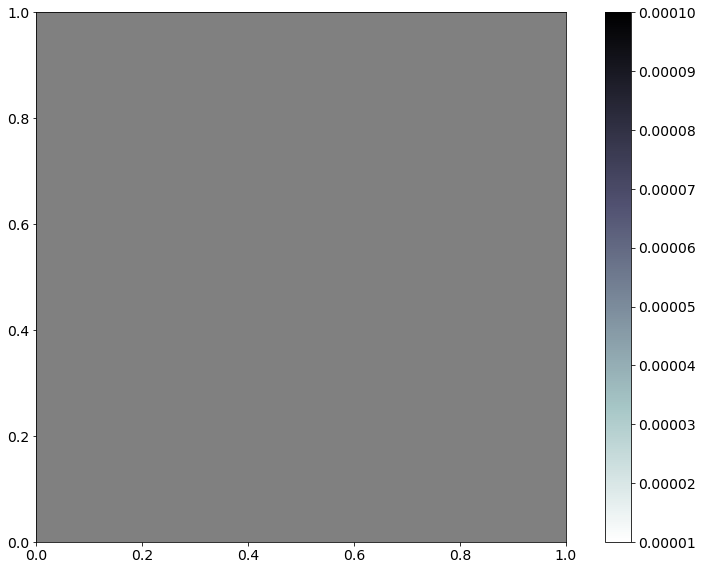

In [19]:
# Make a movie
#dates = pd.date_range('2019-01-01', '2019-06-30',freq='D')
dates = pd.date_range('2019-05-28', '2019-09-24',freq='D')

plt.figure(figsize=(12,8))
ax = plt.subplot(111, facecolor='0.5')
C, T = plot_sstgrad_scene(ax, temp,dates[0],dates[3],)

# def update_scene(ii):
#     t1 = dates[ii]
#     t2 = dates[ii+3]
for t1,t2 in zip(dates[0:-3], dates[3::]):
    print(t1,t2)
    C, T = plot_sstgrad_scene(ax, temp,t1,t2, cbar=False)
    outfile = 'cloudstor/ProjectsActive/TIDE/FIGURES/SSTgrad_{}.png'.format(t1)
    plt.savefig(outfile, dpi=90)
    plt.cla()

In [ ]:
# Make a movie
#dates = pd.date_range('2019-01-01', '2019-06-30',freq='D')
dates = pd.date_range('2019-06-30', '2019-09-24',freq='D')


plt.figure(figsize=(12,8))
ax = plt.subplot(111, facecolor='0.5')
P, C, T = plot_sst_scene(ax, temp,dates[0],dates[3],)

# def update_scene(ii):
#     t1 = dates[ii]
#     t2 = dates[ii+3]
for t1,t2 in zip(dates[0:-3], dates[3::]):
    print(t1,t2)
    P, C, T = plot_sst_scene(ax, temp,t1,t2, cbar=False)
    outfile = 'cloudstor/ProjectsActive/TIDE/FIGURES/SST_{}.png'.format(t1)
    plt.savefig(outfile, dpi=150)
    plt.cla()

